In [1]:
# TODO


In [1]:
# Code to generate theoretical hydropotential subglacial flow paths.
# Code includes both static and evolving flow paths based on a static 
# ice-surface digital elevation model (DEM) and evolving ice thicknesses
# using satellite altimetry.
# 
# Written 2023-11-15 by Wilson Sauthoff (wsauthoff.github.io)

In [3]:
%pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install pysheds

  Using cached pysheds-0.3.5-py3-none-any.whl (89 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import libraries
from datetime import datetime
import earthaccess
import geopandas as gpd
from IPython.display import clear_output
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.legend_handler import HandlerTuple
# import matplotlib.path as mpath
import matplotlib
from matplotlib import colormaps
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import pysheds
from pysheds.grid import Grid
import rioxarray
from shapely.geometry import box
import xarray as xr

# Magic functions
%matplotlib widget

# Define data directories dependent on home environment
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    SCRIPT_DIR = '/home/jovyan/repos_my/script_dir'
    OUTPUT_DIR = '/home/jovyan/3_subglacial_modeling/output/dynamic_subglacial_routing'

# Define utility functions
def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

def ps2ll(x, y):
    """
    Transform coordinates from Antarctic Polar Stereograph
    to geodetic (lon, lat) coordinates
    
    lon, lat = ps2ll(x, y)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy = True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat

# def npdatetime2date(npdatetime):
#     date_str = np.datetime_as_string(npdatetime, unit='D')
#     np_date_only = np.datetime64(date_str)
#     py_date = np_date_only.astype(datetime)
#     formatted_date1 = py_date.strftime('%Y-%m-%d')  # Format as Year-Month-Day
#     return formatted_date1

# def datetime2fracyear(date):
#     start = datetime.date(date.year, 1, 1).toordinal()
#     year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
#     return date.year + float(date.toordinal() - start) / year_length

def datetime64_to_fractional_year(date):
    """
    Convert a numpy.datetime64 object into a fractional year, rounded to 0, .25, .5, or .75.
    """
    year = date.astype('datetime64[Y]').astype(int) + 1970
    start_of_year = np.datetime64(f'{year}-01-01')
    start_of_next_year = np.datetime64(f'{year + 1}-01-01')
    year_length = (start_of_next_year - start_of_year).astype('timedelta64[D]').astype(int)
    day_of_year = (date - start_of_year).astype('timedelta64[D]').astype(int)
    fractional_year = year + day_of_year / year_length

    # Round to nearest quarter
    rounded_fractional_year = round(fractional_year * 4) / 4
    return rounded_fractional_year

# # Example usage
# date = np.datetime64('2024-01-05')
# fractional_year = datetime64_to_fractional_year(date)

# Import datasets

In [6]:
# Log into NASA Earthdata to search for datasets
earthaccess.login()

In [7]:
# Find ICESat-2 ATL14 data granules
results = earthaccess.search_data(
    short_name='ATL14',
    version='003',
    cloud_hosted=True,
    bounding_box=(1, -89, -1, -89)  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
)

Granules found: 4


In [8]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)

Opening 4 granules, approx size: 10.78 GB
using provider: NSIDC_CPRD


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
files

[<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL14/003/ATL14_A3_0318_100m_003_01.nc>,
 <File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL14/003/ATL14_A2_0318_100m_003_01.nc>,
 <File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL14/003/ATL14_A4_0318_100m_003_01.nc>,
 <File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL14/003/ATL14_A1_0318_100m_003_01.nc>]

In [10]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ATL14_A1 = xr.open_dataset(files[3])
ATL14_A2 = xr.open_dataset(files[1])
ATL14_A3 = xr.open_dataset(files[0])
ATL14_A4 = xr.open_dataset(files[2])

In [11]:
# # temporary
# # Specify the variables to keep
# variables_to_keep = ['time', 'y', 'x', 'h']

# variables_to_drop = [var for var in ATL14_A1.variables if var not in variables_to_keep]

# # Drop variables to reduce memory consumption
# ATL14_A1 = ATL14_A1.drop_vars(variables_to_drop)
# ATL14_A1

In [12]:
# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'h']

# List of xarray datasets
datasets = [ATL14_A1, ATL14_A2, ATL14_A3, ATL14_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL14_A1, ATL14_A2, ATL14_A3, ATL14_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [13]:
# # Examine data structure of one of the files
# ATL14_A1

In [14]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL14_A12 = xr.concat([ATL14_A2.isel(x=slice(0,-1)), ATL14_A1], dim="x")

In [15]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL14_A34 = xr.concat([ATL14_A3.isel(x=slice(0,-1)), ATL14_A4], dim="x")

In [16]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated y=0 vector of data
ATL14 = xr.concat([ATL14_A34.isel(y=slice(0,-1)), ATL14_A12], dim=("y"))

In [17]:
# Delete variables to reduce memory consumption
del ATL14_A1, ATL14_A12, ATL14_A2, ATL14_A3, ATL14_A34, ATL14_A4

In [18]:
# Find ICESat-2 ATL15 r003 data granules
# https://doi.org/10.5067/ATLAS/ATL15.003
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.003',
    cloud_hosted=True)

Granules found: 40


In [19]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)

Opening 40 granules, approx size: 5.97 GB


QUEUEING TASKS | :   0%|          | 0/40 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/40 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/40 [00:00<?, ?it/s]

In [20]:
files

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_10km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A

In [21]:
# After viewing files, index the files you wish to open
print(files[15])
print(files[3])
print(files[9])
print(files[11])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A1_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_01km_003_01.nc>


In [22]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ATL15_A1 = xr.open_dataset(files[15], group='delta_h')
ATL15_A2 = xr.open_dataset(files[3], group='delta_h')
ATL15_A3 = xr.open_dataset(files[9], group='delta_h')
ATL15_A4 = xr.open_dataset(files[11], group='delta_h')

In [23]:
# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'delta_h']

# List of xarray datasets
datasets = [ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [24]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A12 = xr.concat([ATL15_A2.isel(x=slice(0,-1)), ATL15_A1], dim="x")

In [25]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A34 = xr.concat([ATL15_A3.isel(x=slice(0,-1)), ATL15_A4], dim="x")

In [26]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated y=0 vector of data
ATL15 = xr.concat([ATL15_A34.isel(y=slice(0,-1)), ATL15_A12], dim=("y"))

In [27]:
# Delete variables to reduce memory consumption
del ATL15_A1, ATL15_A12, ATL15_A2, ATL15_A3, ATL15_A34, ATL15_A4

In [28]:
# Add datasets attributes
ATL15.attrs['identifier_product_DOI'] = '10.5067/ATLAS/ATL15.003'
ATL15.attrs['shortName'] = 'ATL15'

In [29]:
# Assign new data variable of absolute heights (ATL14 DEM + ATL15 dh) to ATL15_dh xarray.Dataset
ATL15 = ATL15.assign(h = ATL15['delta_h'] + ATL14['h'][:,:])
ATL15

<xarray.Dataset>
Dimensions:  (time: 19, x: 5461, y: 4461)
Coordinates:
  * time     (time) datetime64[ns] 2018-10-01T22:30:00 ... 2023-04-02T13:30:00
  * x        (x) float64 -2.67e+06 -2.669e+06 -2.668e+06 ... 2.789e+06 2.79e+06
  * y        (y) float64 -2.19e+06 -2.189e+06 -2.188e+06 ... 2.269e+06 2.27e+06
Data variables:
    delta_h  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    h        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:             delta_h group includes variables describing heig...
    identifier_product_DOI:  10.5067/ATLAS/ATL15.003
    shortName:               ATL15

In [30]:
# Delete variable to reduce memory consumption
del ATL14

In [31]:
# Find cloud-hosted MEaSUREs BedMachine Antarctica bed and surface topography v3
# https://www.doi.org/10.5067/FPSU0V1MWUB6
# More info: https://sites.uci.edu/morlighem/bedmachine-antarctica/
results = earthaccess.search_data(
    doi='10.5067/FPSU0V1MWUB6',
    cloud_hosted=True,
    bounding_box=(1, -89, -1, -89)  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
)

Granules found: 1


In [32]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

Opening 1 granules, approx size: 0.79 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0756.003/1970.01.01/BedMachineAntarctica-v3.nc>]

In [33]:
# Print file name to ensure expected dataset
print(files[0])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0756.003/1970.01.01/BedMachineAntarctica-v3.nc>


In [34]:
# Open dataset
bedmachine = xr.open_dataset(files[0])
bedmachine

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 ...
    firn       (y, x) float32 ...
    surface    (y, x) float32 ...
    thickness  (y, x) float32 ...
    bed        (y, x) float32 ...
    errbed     (y, x) float32 ...
    source     (y, x) int8 ...
    dataid     (y, x) int8 ...
    geoid      (y, x) int16 ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [35]:
# # Use non-cloud-hosted dataset when NSIDC cloud-hosted data is unavailable
# bedmachine = xr.open_dataset(DATA_DIR + '/beds/BedMachine/BedMachineAntarctica-v3.nc')
# bedmachine

In [36]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + 
    '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [37]:
# # Clip BedMachine to grounding line to limit flow routing to only below grounded ice
# bedmachine.rio.write_crs("epsg:3031", inplace=True)
# # bedmachine = bedmachine.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs)

In [38]:
# Specify the variables to keep
variables_to_keep = ['x', 'y', 'surface', 'firn', 'bed']

variables_to_drop = [var for var in bedmachine.variables if var not in variables_to_keep]

# Drop variables to reduce memory consumption
bedmachine = bedmachine.drop_vars(variables_to_drop)
bedmachine

<xarray.Dataset>
Dimensions:  (x: 13333, y: 13333)
Coordinates:
  * x        (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y        (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    firn     (y, x) float32 ...
    surface  (y, x) float32 ...
    bed      (y, x) float32 ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [39]:
# Assign new data variable of static hydropotential to BedMachine xarray.Dataset
rho_ice = 917
rho_water = 997
bedmachine = bedmachine.assign(static_hydropotential_kPa = (9.8 * (rho_ice*(bedmachine['surface']-bedmachine['firn']) + (rho_water-rho_ice)*bedmachine['bed']))/1e3)

In [40]:
# Assign new data variable of hydropotential to ATL15 xarray.Dataset
# Follows Shreve 1972, where h_i=Zsurf-Zbed
# Adds g (gravitational acceleration) to make units Pa and unit converts to kPa
# Use BedMachine Antarctica bed topography for Zbed
rho_ice = 917
rho_water = 997
ATL15 = ATL15.assign(dynamic_hydropotential_kPa_BedMachine = (9.8 * (rho_ice*(ATL15['h']-bedmachine['firn']) + (rho_water-rho_ice)*bedmachine['bed']))/1e3)

In [41]:
# Clip bedmachine to grounding line to limit flow routing to only below grounded ice
bedmachine.rio.write_crs("epsg:3031", inplace=True)
bedmachine = bedmachine.rio.clip(Scripps_landice.geometry.values.buffer(10000), Scripps_landice.crs)

In [42]:
# # Clip ATL15 to grounding line to limit flow routing to only below grounded ice
ATL15.rio.write_crs("epsg:3031", inplace=True)
ATL15 = ATL15.rio.clip(Scripps_landice.geometry.values.buffer(10000), Scripps_landice.crs)

In [43]:
# Import Smith and others, 2017, TC method CryoSat-2 (CS2) SARIn DEM data
# https://doi.org/10.5194/tc-11-451-2017
# (closed source aquired from Ben Smith)
CS2_Smith2017 = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2019.0_relative_to_ATL14.nc')
CS2_Smith2017

<xarray.Dataset>
Dimensions:      (y: 4451, x: 5451, time: 34)
Coordinates:
  * y            (y) float64 -2.185e+06 -2.184e+06 ... 2.264e+06 2.265e+06
  * x            (x) float64 -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
  * time         (time) datetime64[ns] 2010-07-02T15:00:00 ... 2018-10-01T22:...
Data variables:
    mask         (y, x) float64 ...
    data_count   (time, y, x) float64 ...
    spatial_ref  int64 ...
    h            (time, y, x) float64 ...
    delta_h      (time, y, x) float64 ...
Attributes:
    fileName:                mos_2010.5_2021.5.h5
    shortName:               CS2-Smith-2017
    identifier_product_DOI:  doi:10.5194/tc-11-451-2017

In [44]:
# Import subglacial lake outlines 
exec(open(SCRIPT_DIR + '/Sauthoff2024_outlines.py').read())

In [45]:
# MODIS MOA 2014 coastline and grounding line
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp, crs=3031)
# moa_2014_groundingline['geometry'] = moa_2014_groundingline.buffer(0)

In [46]:
# Import MODIS Mosaic of Antarctica surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
# Relocate to data_dir
# Open into an xarray.DataArray
moa_lowres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa750_2014_hp1_v01.tif' 
moa_lowres_da = rioxarray.open_rasterio(moa_lowres)

# moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif' 
# moa_highres_da = rioxarray.open_rasterio(moa_highres)

In [47]:
# # Delete variable to reduce memory consumption
# del bedmachine

In [58]:
# MEaSUREs Antarctic Boundaries for IPY 2007-2009 from Satellite Radar V002 (IMBIE ice drainage basins)
# https://doi.org/10.5067/AXE4121732AD
# https://nsidc.org/sites/default/files/nsidc-0709-v002-userguide.pdf
IMBIE_basins = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/Basins_IMBIE_Antarctica_v02.shp')
# refined_basins = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/Basins_Antarctica_v02.shp')
# ice_boundaries = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/IceBoundaries_Antarctica_v02.shp')
# grounded_ice_boundaries = ice_boundaries[ice_boundaries["TYPE"]=='GR']

# Preprocess data

In [49]:
# dataset1=CS2_Smith2017
dataset1='none'
dataset2=ATL15

# Create empty lists to store data
cyc_start_dates = []
cyc_end_dates = []
midcyc_dates = []

# Skip processing for dataset1 if it is 'none'
if dataset1 != 'none':
    for idx in range(len(dataset1.delta_h[:33])):
        # Smith and others, 2017 method CryoSat-2 SARIn data
        if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
            cyc_start_date = dataset1.time.values[idx]
            cyc_end_date = dataset1.time.values[idx+1]
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
        # Cryo-TEMPO-EOLIS Swath Thematic Gridded Product 
        elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
            date_time_str = '70-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            cyc_start_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
            cyc_end_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
            midcyc_days = cyc_end_date - cyc_start_date
            midcyc_date = cyc_start_date + midcyc_days/2
            cyc_start_dates += [cyc_start_date]
            cyc_end_dates += [cyc_end_date]
            midcyc_dates += [midcyc_date]
for idx in range(len(dataset2.delta_h)-1):
    # ICESat-2 ATL15 r003
    if dataset2.identifier_product_DOI == '10.5067/ATLAS/ATL15.003':    
        cyc_start_date = dataset2.time.values[idx]
        cyc_end_date = dataset2.time.values[idx+1]
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]

In [50]:
x, y = ll2ps(0, -88)
center_x = 0
center_y = 0
radius = y
IS2_pole_hole = Point(center_x, center_y).buffer(radius)
IS2_pole_hole_gdf = gpd.GeoDataFrame(index=[0], geometry=[IS2_pole_hole], crs="EPSG:3031")

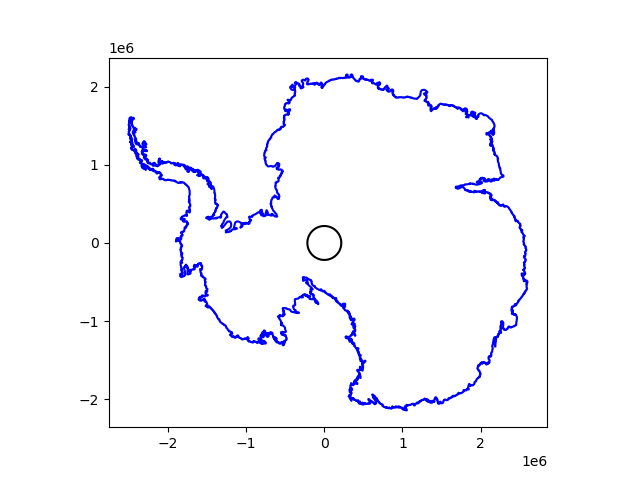

In [51]:
fig, ax = plt.subplots()

Scripps_landice.boundary.plot(ax=ax, color='blue')
IS2_pole_hole_gdf.boundary.plot(ax=ax, color='k')
plt.show()

In [52]:
# Find evolving subglacial flow routing and store as geopandas geodataframe and export for later use

# Create empty geopandas geodataframe to store flow pathway branches
branches_gdf = gpd.GeoDataFrame()

for i in range(len(ATL15['time'].values)):
# for i in range(2):
    # Print progress updates
    print('Working on time slice:', ATL15['time'].values[i])

    # Define array
    arr = ATL15['dynamic_hydropotential_kPa_BedMachine'][i,:,:]

    # Write CRS
    arr3031 = arr.rio.write_crs("EPSG:3031")
    
    # Specify the output raster file path
    output_raster_path = 'output_raster.tif'
    
    # Convert xarray DataArray to raster and save it
    arr3031.rio.to_raster(output_raster_path)
        
    grid = pysheds.grid.Grid.from_raster('output_raster.tif')
    dem = grid.read_raster('output_raster.tif')
    
    # Delete tiff file
    os.remove('output_raster.tif')

    # Fill pits
    pit_filled_dem = grid.fill_pits(dem)

    # Fill depressions
    flooded_dem = grid.fill_depressions(pit_filled_dem)

    # Resolve flats and compute flow directions
    inflated_dem = grid.resolve_flats(flooded_dem)
    fdir = grid.flowdir(inflated_dem)
    
    # Compute accumulation
    acc = grid.accumulation(fdir)

    # Store branches and datetimes
    branches = grid.extract_river_network(fdir, acc > 1000)
    new_gdf = gpd.GeoDataFrame.from_features(branches)#, crs=3031)
    # new_gdf.set_geometry
    new_gdf.set_crs(epsg=3031, inplace=True)
    new_gdf = new_gdf.clip(Scripps_landice.geometry, Scripps_landice.crs)
    # new_gdf = gpd.overlay(new_gdf, gpd.GeoDataFrame(geometry=[IS2_pole_hole]), how='intersection')
    new_gdf = gpd.overlay(new_gdf, IS2_pole_hole_gdf, how='difference')
    new_gdf['datetime'] = ATL15['time'].values[i]   
    branches_gdf = pd.concat([branches_gdf, new_gdf])
    
    # Clear the output of each index
    clear_output(wait=True)

Working on time slice: 2023-04-02T13:30:00.000000000


/srv/conda/envs/notebook/lib/python3.10/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


# Analysis

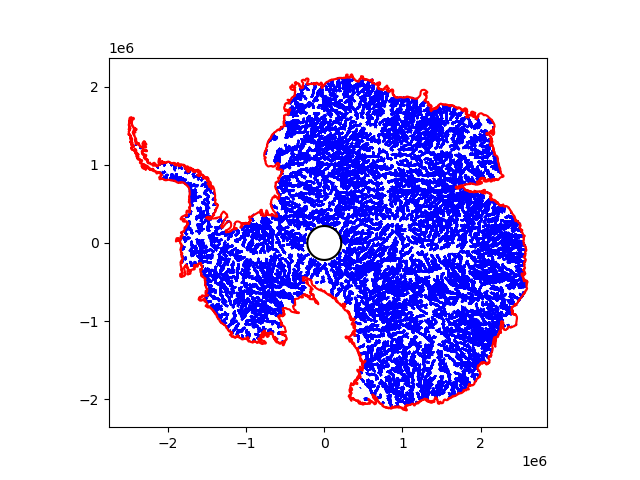

In [53]:
fig, ax = plt.subplots()

branches_gdf.plot(ax=ax, color='blue')
Scripps_landice.boundary.plot(ax=ax, color='red')
IS2_pole_hole_gdf.boundary.plot(ax=ax, color='k')
plt.show()

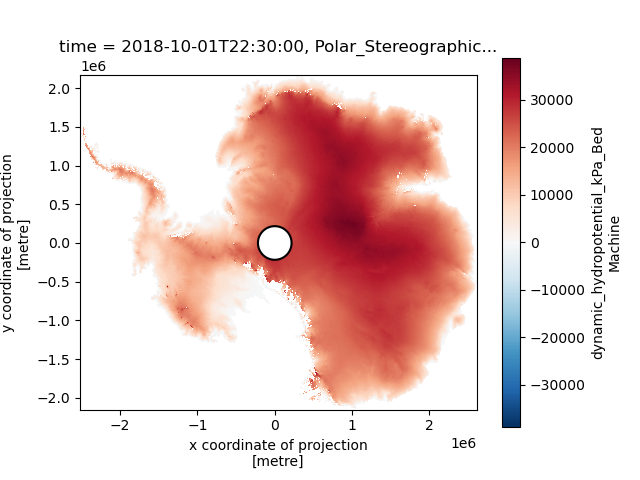

In [54]:
fig, ax = plt.subplots()

IS2_pole_hole_gdf.boundary.plot(ax=ax, color='k')
ATL15['dynamic_hydropotential_kPa_BedMachine'][0,:,:].plot(ax=ax)

In [55]:
# # Clip ATL15 to grounding line to limit flow routing to only below grounded ice
# # ATL15.rio.write_crs("epsg:3031", inplace=True)
# branches_gdf = branches_gdf.clip(Scripps_landice.geometry, Scripps_landice.crs)

In [ ]:
# # Export geodataframe
# # branches_gdf.to_file("IS2_branches.shp")
# branches_gdf.to_file("IS2_branches.geojson", driver='GeoJSON')
# branches_gdf.to_file("IS2_branches.gpkg", layer='branches', driver="GPKG")

# # Converting geometry to WKT
# branches_gdf['geometry'] = branches_gdf['geometry'].apply(lambda x: x.wkt)

# # Exporting to CSV
# branches_gdf.to_csv('IS2_branches.csv', index=False)

In [ ]:
# for i, value in enumerate(IMBIE_basins['NAME']):
#     if i == 0:  # Skip 0th basin since it is the islands
#         continue
#     print(f"Processing index {i}/{len(IMBIE_basins)}: basin {value}")
#     basin = IMBIE_basins.iloc[[i]]
#     evolving_flow_pathways_inefficient_IS2(basin)
    
# # some don't plot plot branches properly, investigate
# # 19th basin doesn't plot, fix

In [ ]:
# basin = IMBIE_basins[IMBIE_basins.NAME == 'Ep-F']
# evolving_flow_pathways_inefficient_IS2(basin)
    
# # some don't plot branches properly, investigate
# # 19th basin doesn't plot, fix

In [79]:
# Plot evolving outlines

# dataset1 = CS2
dataset2 = ATL15
   
# Plot figure
fig, ax = plt.subplots(figsize=(10,10))

x_min = dataset2.x.min()
x_max = dataset2.x.max()
y_min = dataset2.y.min()
y_max = dataset2.y.max()

# # Subset MOA imagery to region of interest using data masks
# mask_x = (moa_highres_da.x >= x_min) & (moa_highres_da.x <= x_max)
# mask_y = (moa_highres_da.y >= y_min) & (moa_highres_da.y <= y_max)
# moa_highres_da_sub = moa_highres_da.where(mask_x & mask_y, drop=True)

# # Subset MOA imagery to region of interest using data masks
# mask_x = (moa_lowres_da.x >= x_min) & (moa_lowres_da.x <= x_max)
# mask_y = (moa_lowres_da.y >= y_min) & (moa_lowres_da.y <= y_max)
# moa_lowres_da_sub = moa_lowres_da.where(mask_x & mask_y, drop=True)

# Plot MOA imagery  
# ax.imshow(moa_highres_da_sub[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min, x_max, y_min, y_max])
# ax.imshow(moa_lowres_da_sub[0,:,:], cmap="gray", clim=[14000, 17000], 
#           extent=[x_min, x_max, y_min, y_max])

# Pick colormap and make continuous cmap discrete
# cmap = cm.get_cmap('viridis', len(ATL15['dynamic_hydropotential_kPa_BedMachine']))
# cmap = cm.get_cmap('viridis_r', len(ATL15['time'].values))
cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Norm to time variable
# norm = plt.Normalize(mdates.date2num(ATL15['time'][0].values), 
#                      mdates.date2num(ATL15['time'][-1].values))
norm = plt.Normalize(datetime64_to_fractional_year(midcyc_dates[0]), datetime64_to_fractional_year(midcyc_dates[-1]))
  
# Set colormap and normalize to date values
# cmap = plt.get_cmap('plasma', len(midcyc_dates)-1)
m = plt.cm.ScalarMappable(cmap=cmap)
# m.set_array(np.array([datetime64_to_fractional_year(date) for date in midcyc_dates[0:-1]]))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="2.5%", pad=0.75)
fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=10)

lines=[]
for idx, dt in enumerate(cyc_start_dates):
    print(dt)
    x = 1; y = 1
    line, = ax.plot(x, y, 
                    color=cmap(norm(datetime64_to_fractional_year(midcyc_dates[idx]))), 
                    linewidth=3)
    lines.append(line)
    
    # Filter rows that match the current time slice
    if any(branches_gdf[branches_gdf['datetime'] == dt]):
        branches_gdf[branches_gdf['datetime'] == dt].plot(ax=ax, 
            # color=cmap(norm(datetime64_to_fractional_year(midcyc_dates[idx]))), 
            linewidth=0.5)
    
# Overlay published outlines for visual comparison and grounding line
S09_color = 'lightseagreen'
SF18_color = 'teal'
# Smith2009_outlines.boundary.plot(ax=ax, edgecolor=S09_color, facecolor=S09_color, linestyle=(0, (1, 3)), linewidth=3, alpha=0.5, zorder=2)
# SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor=SF18_color, facecolor=SF18_color, linestyle=(0, (1, 1)), linewidth=3, alpha=0.5, zorder=2)
SiegfriedFricker2018_outlines.boundary.plot(ax=ax, edgecolor=SF18_color, facecolor=SF18_color, linestyle=(0, (1, 1)), linewidth=3, alpha=0.5, zorder=2)
Scripps_landice.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)

# Set axes limits
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# Change polar stereographic m to km for cleaner-looking axes
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.yaxis.set_major_formatter(ticks_y)  

# Label axes
ax.set_xlabel('x [km]', size=20)
ax.set_ylabel('y [km]', size=20)
plt.tick_params(axis='both', which='both', labelleft=False, labelright=True, left=False, right=True)

# Create lines for legend
# Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=4)
SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 1)), linewidth=3)
gl = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=3)
routing = plt.Line2D((0, 1), (0, 0), color='b', linestyle='-', linewidth=3)

# Create legend
ax.legend(handles=[
    # Smith2009, 
    SiegfriedFricker2018, 
    # tuple(lines),
    gl,
    tuple(lines)], 
    labels=['static lake outlines (Siegfried & Fricker, 2018)', 
            # 'static lake outline [7]', 
        # 'evolving lake outlines [this study]', 
            'grounding line (Depoorter and others, 2013)',
         'evolving subglacial routing (this study)'], 
          handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        # bbox_to_anchor=(0.55, 1), 
          loc='upper left')

# # Plot inset map to show location 
# axIns = ax.inset_axes([0.715, 0.68, 0.33, 0.33]) # [left, bottom, width, height] (fractional axes coordinates)
# axIns.set_aspect('equal')
# moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=1)
# moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1) 
# rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k')
# axIns.add_artist(rect) 
# axIns.axis('off')

# ax.set_title('Evolving subglacial flow routing \nduring ICESat-2 era {} to {}'.format(datetime64_to_fractional_year(ATL15.time[0].values), datetime64_to_fractional_year(ATL15.time[-1].values)), pad=7.5, fontsize=17.5)

# Save and show fig
# plt.savefig('/home/jovyan/0_output/Antarctica/evolving_subglacial_routing_IS2')

plt.show()

2018-10-01T22:30:00.000000000
2019-01-01T06:00:00.000000000
2019-04-02T13:30:00.000000000
2019-07-02T21:00:00.000000000
2019-10-02T04:30:00.000000000
2020-01-01T12:00:00.000000000
2020-04-01T19:30:00.000000000
2020-07-02T03:00:00.000000000
2020-10-01T10:30:00.000000000
2020-12-31T18:00:00.000000000
2021-04-02T01:30:00.000000000
2021-07-02T09:00:00.000000000
2021-10-01T16:30:00.000000000
2022-01-01T00:00:00.000000000
2022-04-02T07:30:00.000000000
2022-07-02T15:00:00.000000000
2022-10-01T22:30:00.000000000
2023-01-01T06:00:00.000000000


ValueError: Date ordinal -2153000.0 converts to -3925-04-15T00:00:00.000000 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous view', 'arrow-left', 'back'), ('Forward', 'Forward to next view', 'arrow-right', 'forward'), ('Pan', 'Left button pans, Right button zooms\nx/y fixes axis, CTRL fixes aspect', 'arrows', 'pan'), ('Zoom', 'Zoom to rectangle\nx/y fixes axis', 'square-o', 'zoom'), ('Download', 'Download plot', 'floppy-o', 'save_figure')]))

In [80]:
cyc_start_dates

[numpy.datetime64('2018-10-01T22:30:00.000000000'),
 numpy.datetime64('2019-01-01T06:00:00.000000000'),
 numpy.datetime64('2019-04-02T13:30:00.000000000'),
 numpy.datetime64('2019-07-02T21:00:00.000000000'),
 numpy.datetime64('2019-10-02T04:30:00.000000000'),
 numpy.datetime64('2020-01-01T12:00:00.000000000'),
 numpy.datetime64('2020-04-01T19:30:00.000000000'),
 numpy.datetime64('2020-07-02T03:00:00.000000000'),
 numpy.datetime64('2020-10-01T10:30:00.000000000'),
 numpy.datetime64('2020-12-31T18:00:00.000000000'),
 numpy.datetime64('2021-04-02T01:30:00.000000000'),
 numpy.datetime64('2021-07-02T09:00:00.000000000'),
 numpy.datetime64('2021-10-01T16:30:00.000000000'),
 numpy.datetime64('2022-01-01T00:00:00.000000000'),
 numpy.datetime64('2022-04-02T07:30:00.000000000'),
 numpy.datetime64('2022-07-02T15:00:00.000000000'),
 numpy.datetime64('2022-10-01T22:30:00.000000000'),
 numpy.datetime64('2023-01-01T06:00:00.000000000')]